# TSIA202b - Second Practice Session : Spectral estimation

In this practical work, we propose to compare nonparametric spectral estimators (periodogram, smoothed periodogram) with parametric estimators (linear prediction, Capon, Durbin methods), in the case of three types of processes commonly encountered : autoregressive processes, sum of noisy sinusoids, and autoregressive-moving-average processes.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy

## 1. Autoregressive process

### 1.1. Synthesis

1. Code a function that synthesizes an autoregressive (AR) process of length N, defined by its AR coefficients and the innovation variance $\sigma ^2$

___

Let's denote $(\phi _i)_{(1\leq i \leq p)}$ the AR(p) coefficients.

The AR(p) process is defined as follows :

$$ X_t = \sum ^p _{i=1} X_{t-i} \phi _i + Z_t $$

$$ Z_t \sim \mathcal{N} (0,\sigma^2) $$

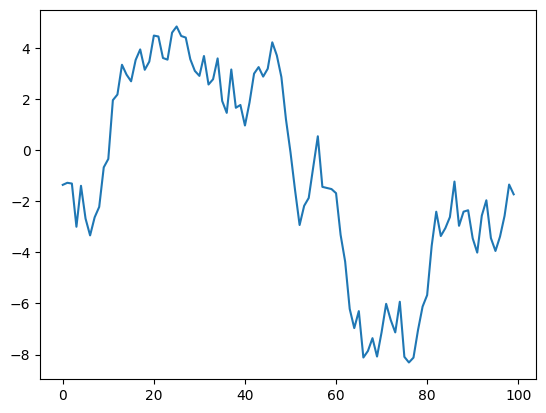

In [3]:
def autoregressive_process(coeffs, sigma2, N):
    p = len(coeffs) # AR(p) autoregressive process
    noise = np.random.normal(0, np.sqrt(sigma2), N)  # White noise of variance sigma² (innovation process)
    x = np.zeros(N)
    for t in range(N): # For each variable of our process
        for i in range(p): # For each autoregressive coefficient
            if t > i: # The t-th variable is generated with the t > i >= 0 other variables
                x[t] += coeffs[i]*x[t-i-1]
        x[t] += noise[t]
    return x

ar_coeffs = [1]  # Random walk AR(1) process
sigma2 = 1.0
N = 100
plt.plot([i for i in range(N)], autoregressive_process(ar_coeffs, sigma2, N))

### 1.2. Non-parametric estimation : periodogram

2. Code a function that computes and displays the periodogram of a given input signal, allowing to choose between the standard method and the Bartlett and Welsh methods.

___

Since $FFT(X)(\nu) = \sum^N _{t=1} X_t e^{-2i\pi \nu t}$

##### Standard method for periodogram :

$$ \hat{S}_{P,XX}(\nu) = \frac{1}{N} |{\sum^N _{t=1} X_t e^{-2i\pi \nu t}}|^2 $$

$$ \hat{S}_{P,XX}(\nu) = \frac{1}{N} |FFT(X)(\nu)|^2 $$

##### Bartlett method for periodogram :

The $N$ signal samples are segmented into $L$ sub-samples of size $M = \frac{N}{L}$ 

$$ \hat{S}_{B,XX}(\nu) = \frac{1}{L} \sum^L _{i=1} \frac{1}{M}|{\sum^M _{t=1} X_{(i-1)M+t} e^{-2i\pi \nu t}}|^2 $$

$$ \hat{S}_{B,XX}(\nu) = \frac{1}{L} \sum^L _{i=1} \frac{1}{M}|FFT(\widetilde{X})(\nu)|^2 $$

With $\widetilde{X} = X_{(i-1)M+t} $ the $i^{\text{th}}$ sample from the segmented signal

##### Welsh method for periodogram :

This method adds data segments overlap and each data segment is windowed.

$$ \hat{S}_{W,XX}(\nu) = \frac{1}{S} \sum^S _{i=1} \hat{S}^{(i)}_{P,XX}(\nu) $$

With :

$$ \hat{S}^{(i)}_{P,XX}(\nu) = \frac{1}{MP} |{\sum^M _{t=1} \nu (t) X_{(i-1)K+t} e^{-2i\pi \nu t}}|^2 $$

Recommended choice is $K = \frac{M}{2}$ and $S \approx \frac{2N}{M}$.

$\nu (t)$ denotes the window

$P = \frac{1}{N} \sum ^M _{i=t} |\nu (t)|^2$ normalizes every periodogram

In [157]:
methods = ["Standard","Bartlett","Welsh"]

def compute_periodogram(X,fs=1.0,method='Standard',L=8,plot_periodogram=True,semilogy_plot = True, plot_aeiou_frequencies = False):
    N = len(X)
    freqs = np.fft.fftfreq(N, 1/fs)

    if method not in methods :
        print(f"Method must be in {methods}")
        return()

    if method == 'Standard':
        Sxx = (np.abs(np.fft.fft(X))**2)/N

    elif method == 'Bartlett':
        M = N//L #Data segment size
        Sxx = np.zeros(M)
        for i in range(L):
            segment = X[i*M : (i+1)*M] #We take {X[iM], ... X[(i+1)M-1]} to compute
            Sxx += (np.abs(np.fft.fft(segment, M))**2)/M
        Sxx = Sxx/L
        freqs = np.fft.fftfreq(M, 1/fs)
    
    elif method == 'Welsh': #We will use hann window for Welsh
        M = N//L
        K = M//2  #Recommended overlapping size
        S = 2*N//M #Number of segments used to average Sxx
        window = np.hanning(M)
        P = np.sum(window**2)/M #Normalizing coefficient
        Sxx = np.zeros(M)
        for i in range(S):
            j = i*K
            if j + M > N: #If we exceed in length
                break
            segment = X[j:j + M]*window
            Sxx += (np.abs(np.fft.fft(segment, M))**2)/(M*P)
        Sxx = Sxx/S
        freqs = np.fft.fftfreq(M, d=1/fs)
    
    if plot_periodogram:
        plt.figure(figsize=(10, 6))
        if plot_aeiou_frequencies:
            plt.plot([130,130],[0,0.1], color = 'black') #For 'a' vowel, F0
            plt.plot([800,800],[0,0.1], color = 'black') #For 'a' vowel, F1
        if semilogy_plot:
            plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2]) #We use semilogy to compute the periodogram in log scale
        else :
            plt.plot(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2]) #We use semilogy to compute the periodogram in log scale
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Periodogram')
        plt.title(f'Periodogram computed using {method} method')
        plt.grid()
        plt.show()
    return(Sxx,freqs)

3. Display the periodograms obtained with the different methods (in dB), in the case of an AR process of order 1 whose parameters can be chosen by hand. We will superimpose in each case the periodogram with the known power spectral density (PSD) of the AR process. We will pay attention to the correct normalization of the different estimators.

4. Experimentally compare these different estimators in terms of bias and variance

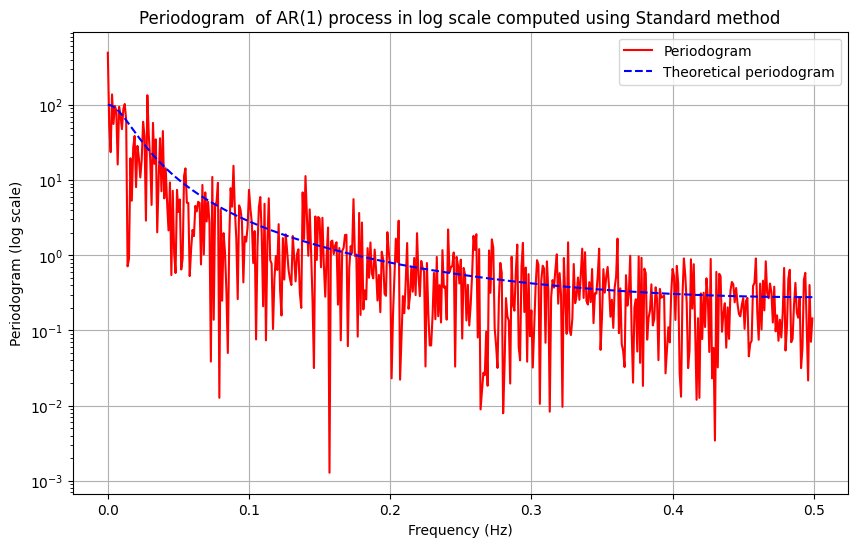

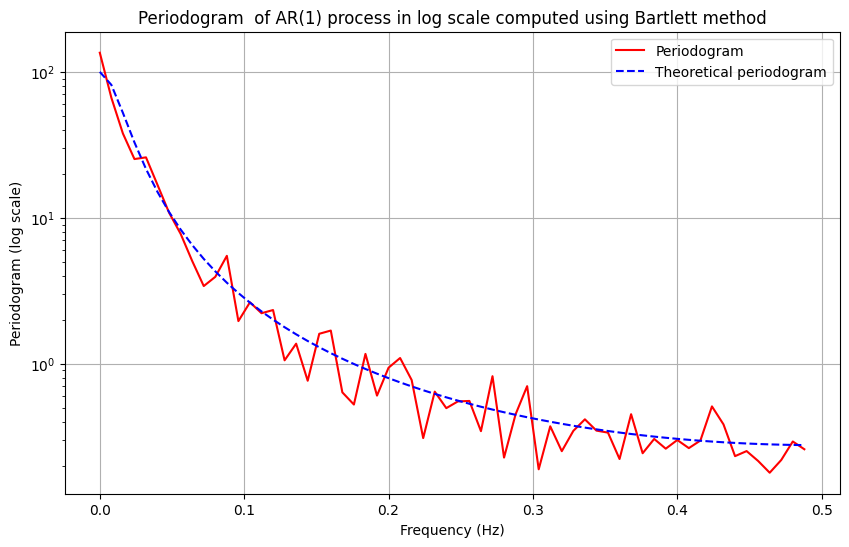

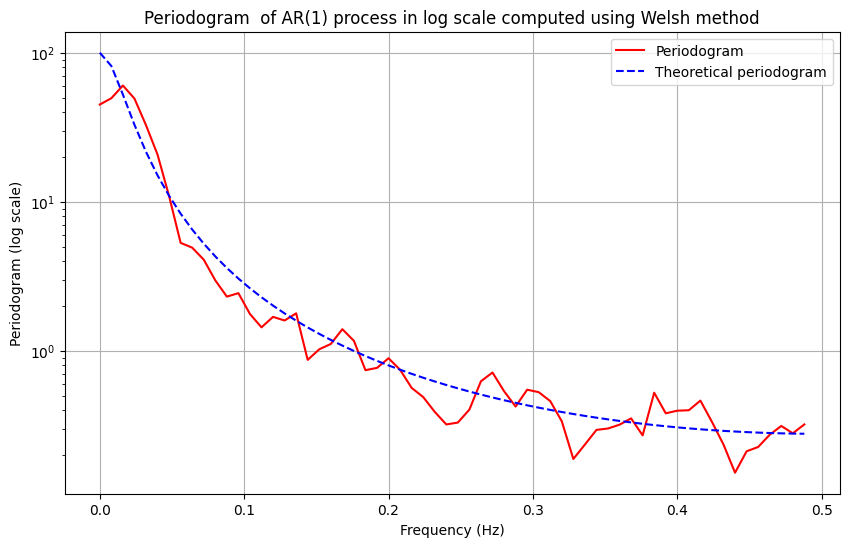

In [146]:
N = 1000
sigma2 = 1

def plot_AR1_process(AR1_parameter,fs=1.0,method='Standard',L=8):
    X = autoregressive_process([AR1_parameter],sigma2,N)
    Sxx, freqs = compute_periodogram(X,fs,method,L,plot_periodogram=False)
    true_Sxx = sigma2/(1-2*AR1_parameter*np.cos(2*np.pi*freqs)+AR1_parameter**2)
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2], label = 'Periodogram', color = 'r') #Because it's symetric
    plt.semilogy(freqs[:len(freqs)//2], true_Sxx[:len(true_Sxx)//2], label = 'Theoretical periodogram', color = 'b', linestyle='dashed')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Periodogram (log scale)')
    plt.legend()
    plt.title(f'Periodogram  of AR(1) process in log scale computed using {method} method')
    plt.grid()
    plt.show()
    
plot_AR1_process(0.9,method='Standard')
plot_AR1_process(0.9,method='Bartlett')
plot_AR1_process(0.9,method='Welsh')


4] The estimators don't have any bias, which means that if we were to plot a lot of periodogram and average them, we would eventually find the theoretical periodogram.

However, in terms of variance the Welsh method is the smoothest one, as it follows the theoretical periodogram. The Bartlett method also has similar smoothness, but has more 'spikes' in its plot.

The standard method has really high variance : the standard method seems inefficient compared to the Welsh and Bartlett methods in terms of Variance.
___

### 1.3. Parametric estimation : linear prediction

5. Estimate the AR model using either the code you wrote in the previous practical work of TSIA202a,
or the function lpc (linear prediction method) from Matlab or from the librosa Python package.

6. Superimpose the spectral envelope of the estimated AR model with that of the exact AR model
and with the periodogram. Comment.
___

5] In the last practical work of TSIA202a, we used Yule-Walker equations to find the AR(p) coefficients and the variance of the white noise added.

We could copy the code, but using the librosa library is much easier :

In [147]:
def estimate_AR_model(X,order=1):
    lpc_coeffs = librosa.lpc(X, order = order)
    return(lpc_coeffs)


According to the description of the librosa library :

"This function applies Burg's method to estimate coefficients of a linear filter. Burg's method is an extension to the Yule-Walker approach."
___

6]

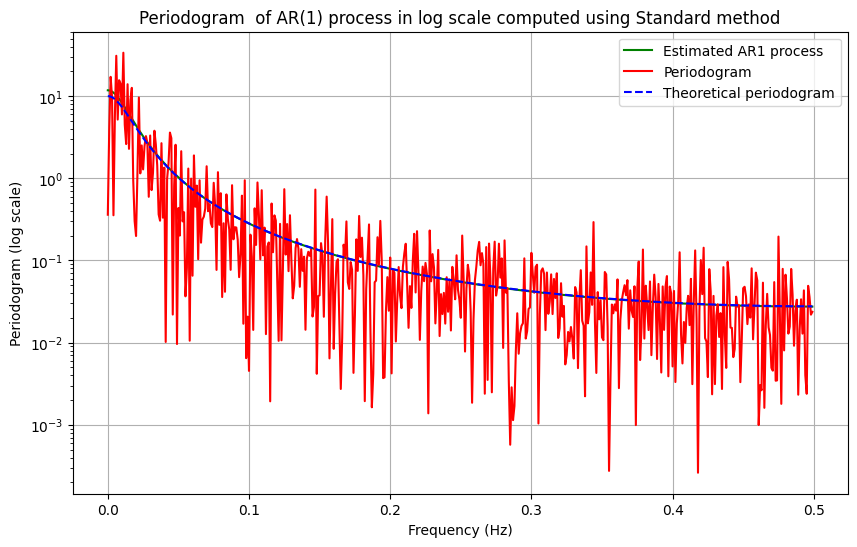

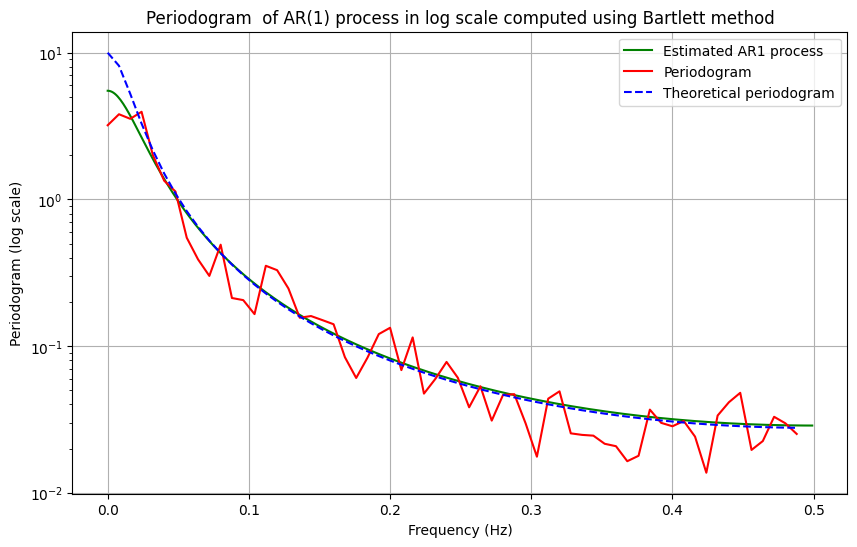

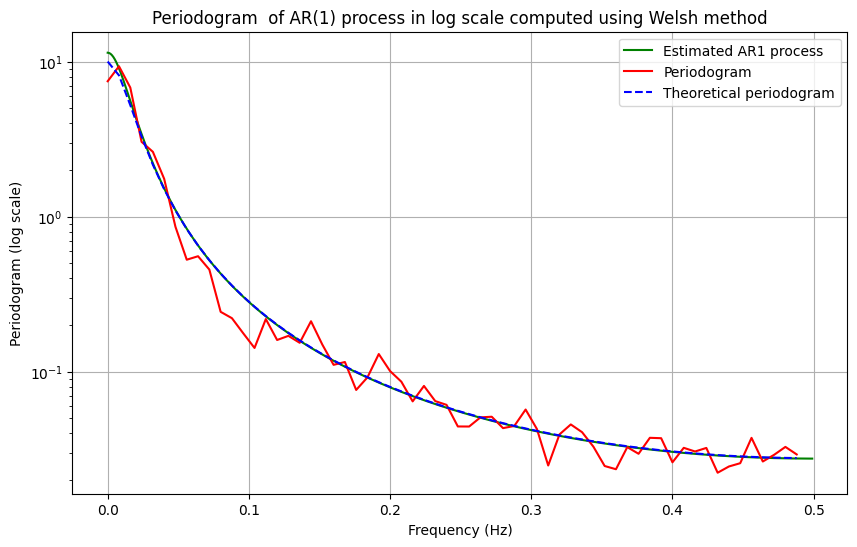

In [148]:
N = 1000
sigma2 = 0.1

def plot_estimated_AR1_process(AR1_parameter,fs=1.0,method='Standard',L=8):
    X = autoregressive_process([AR1_parameter],sigma2,N)
    Sxx, freqs = compute_periodogram(X,fs,method,L,plot_periodogram=False)
    true_Sxx = sigma2/(1-2*AR1_parameter*np.cos(2*np.pi*freqs)+AR1_parameter**2)
    coeff_estimated = estimate_AR_model(X,1)
    estimated_AR1 = sigma2/np.abs(np.fft.fft(coeff_estimated, N))**2
    _, estimated_AR1_freqs = compute_periodogram(X,fs,method='Standard',L=L,plot_periodogram=False) #Didn't find any other way around
    plt.figure(figsize=(10, 6))
    plt.semilogy(estimated_AR1_freqs[:len(estimated_AR1_freqs)//2],estimated_AR1[:len(estimated_AR1_freqs)//2], label = 'Estimated AR1 process', color = 'g')
    plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2], label = 'Periodogram', color = 'r')
    plt.semilogy(freqs[:len(freqs)//2], true_Sxx[:len(true_Sxx)//2], label = 'Theoretical periodogram', color = 'b', linestyle='dashed')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Periodogram (log scale)')
    plt.legend()
    plt.title(f'Periodogram  of AR(1) process in log scale computed using {method} method')
    plt.grid()
    plt.show()
    
plot_estimated_AR1_process(0.9,method='Standard')
plot_estimated_AR1_process(0.9,method='Bartlett')
plot_estimated_AR1_process(0.9,method='Welsh')

The spectral enveloppe of the estimated AR(1) process looks the same as the spectral enveloppe of the exact AR(1) process, which either means that the Burgs (Yule-Walker) equations to predict the AR(1) coefficient is efficient, or that the noise is disrupting too much the AR(1) signal so the estimated spectral enveloppe looks precise (when in reality it only 'looks' precise because of the noise).

It can also be both at the same time.

___

### 1.4 Application to speech signals

7. Apply the above methods to a vowel sound (such as ’a’ for example, that we can extract from file aeiou.wav, downloadable from the eCampus website of TSIA202b), and superimpose the estimated spectra. Comment.

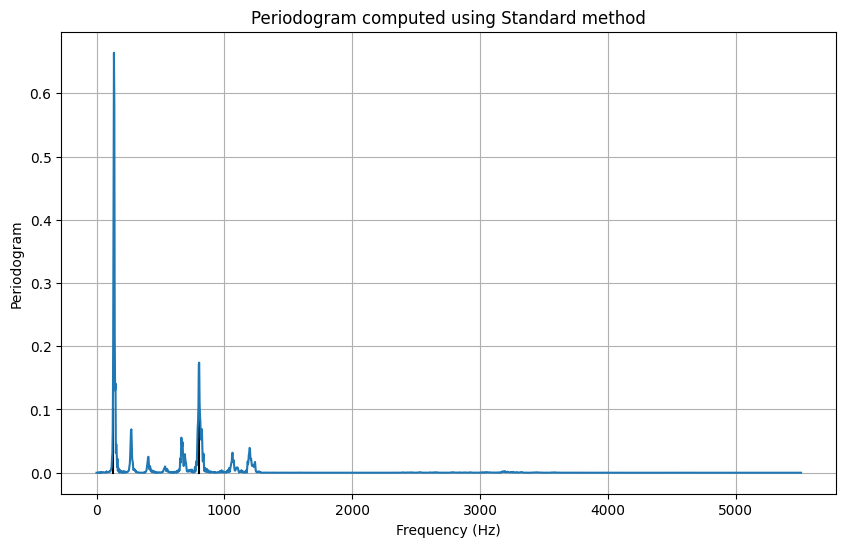

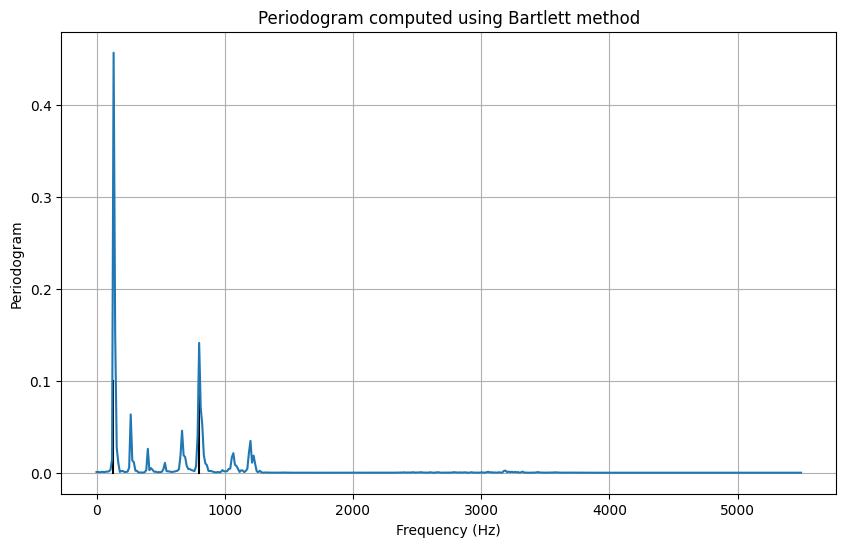

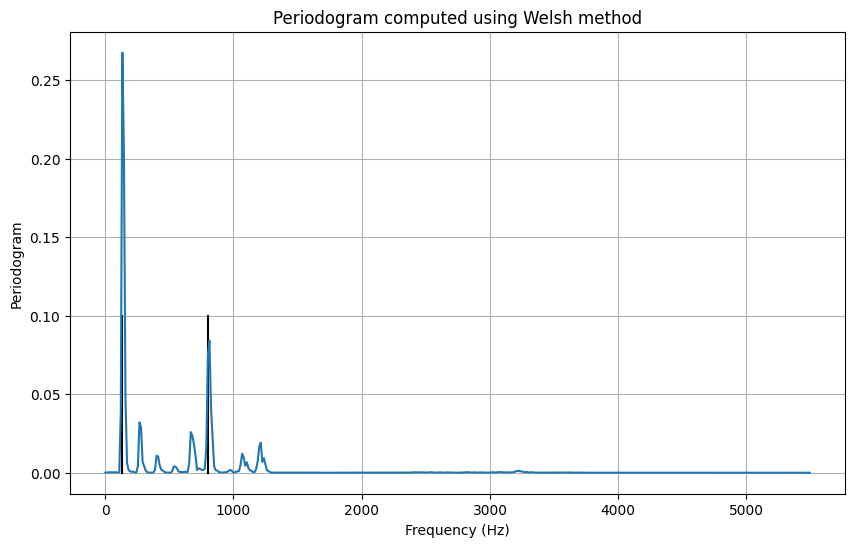

In [158]:
def analyze_a_vowel(file_path, method='Standard'):
    X, sr = librosa.load(file_path, sr=None)
    X = X[:int(0.33*sr)] #First 0.33 seconds of file, which is 'a' vowel sound
    compute_periodogram(X,fs=sr,method=method,L=4,plot_periodogram=True,semilogy_plot = False, plot_aeiou_frequencies = True)

analyze_a_vowel('aeiou.wav', method='Standard')
analyze_a_vowel('aeiou.wav', method='Bartlett')
analyze_a_vowel('aeiou.wav', method='Welsh')

The three methods all give the same base frequency for a 'a' vowel, which is around $F_0 = 130$ Hz

Then they all give the second frequency, which is around $F_1 = 800$ Hz

___

## 2 Sum of noisy sinusoids
### 2.1 Synthesis
1. Code a function that synthesizes a signal of length N, consisting of the sum of K real sinusoids defined by their frequencies, amplitudes and origin phases, and a Gaussian white noise of variance $\sigma ^2$

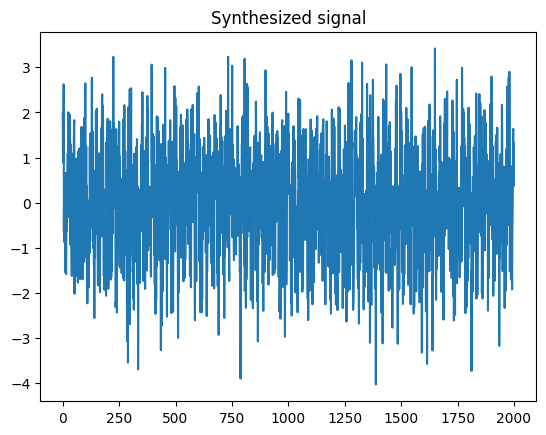

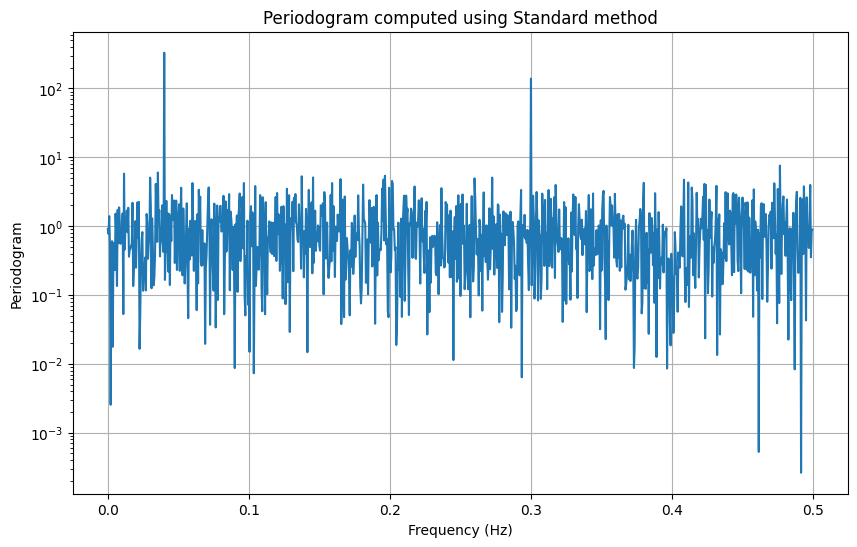

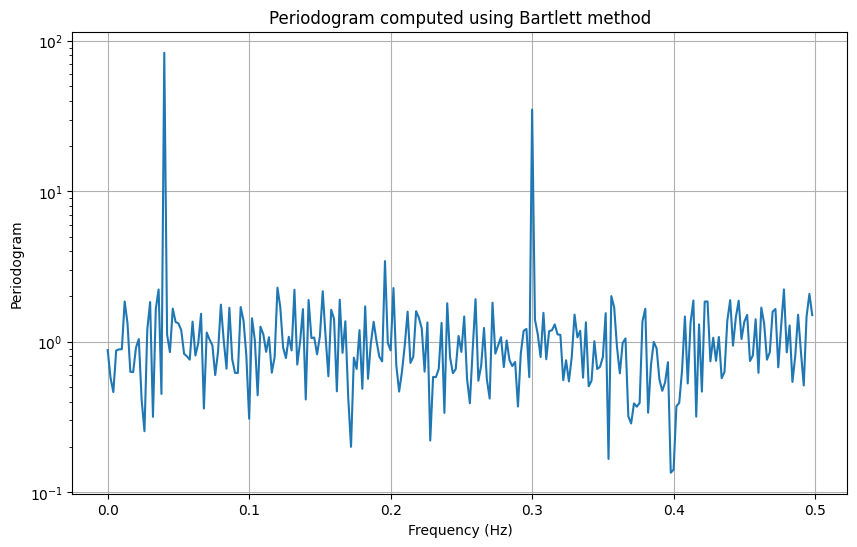

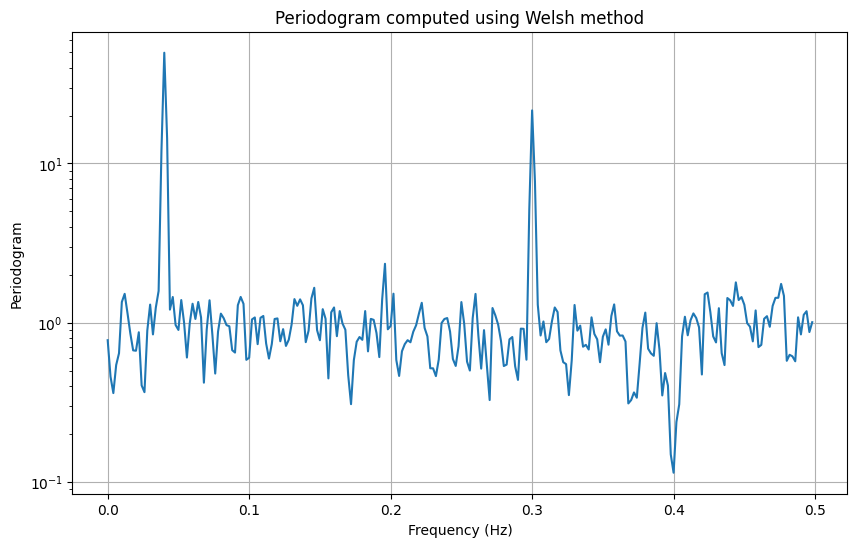

In [ ]:
def synthesize_signal(N,freqs,amps=None,phases=None,sigma2=1):
    t = np.arange(N)
    signal = np.zeros(N)
    if amps == None:
        amps = np.ones(len(freqs))
    if phases == None:
        phases = np.zeros(len(freqs))
    for k in range(len(freqs)):
        signal += amps[k]*np.cos(2*np.pi*freqs[k]*t + phases[k])
    noise = np.random.normal(0, np.sqrt(sigma2), N)
    signal += noise
    return (signal,t)

N = 2000
freqs = [0.04, 0.3]
amps = [0.8, 0.5]
signal, t = synthesize_signal(N, freqs, amps)

plt.plot(t,signal)
plt.title("Synthesized signal")

_, _ = compute_periodogram(signal,fs=1,method="Standard",L=1,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Bartlett",L=4,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Welsh",L=4,plot_periodogram=True)


All methods seem to be more precise, and give the correct frequencies. We can argue that the Welsh and Bartlett methods have higher spectral leakage than the standard method in this example.
___

3] Compare the resolution of the various periodograms, by varying the difference :

∆ν = |ν1 − ν2| 

between both frequencies, as well as the signal-to-noise ratio (SNR) in dB

$SNR = 10 \log _{10}(\frac{A_1^2 + A_2^2}{2\sigma ^2})$ For amps = $[A_1^2, A_2^2]$ and Gaussian white noise of variance $\sigma ^2$

___


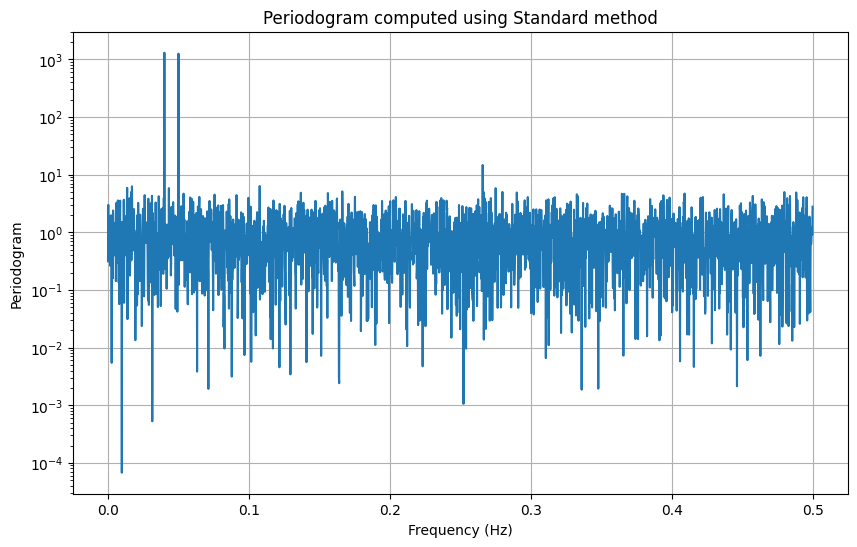

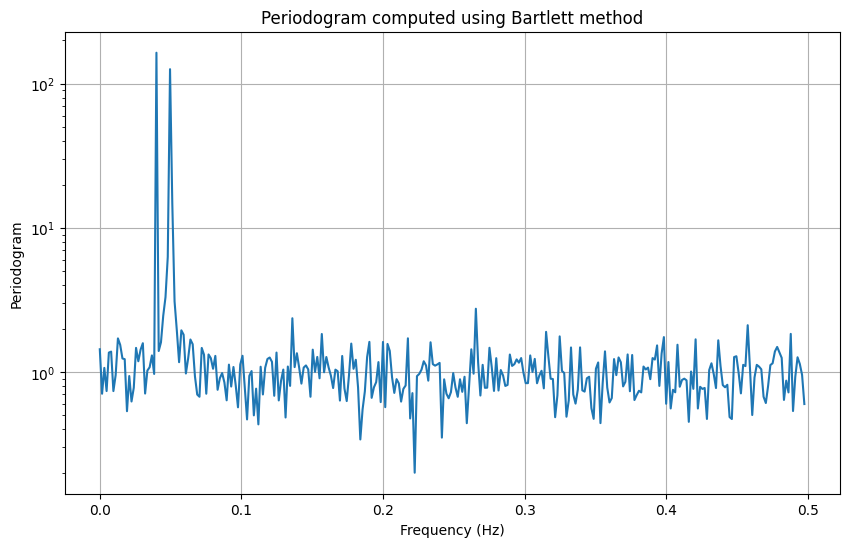

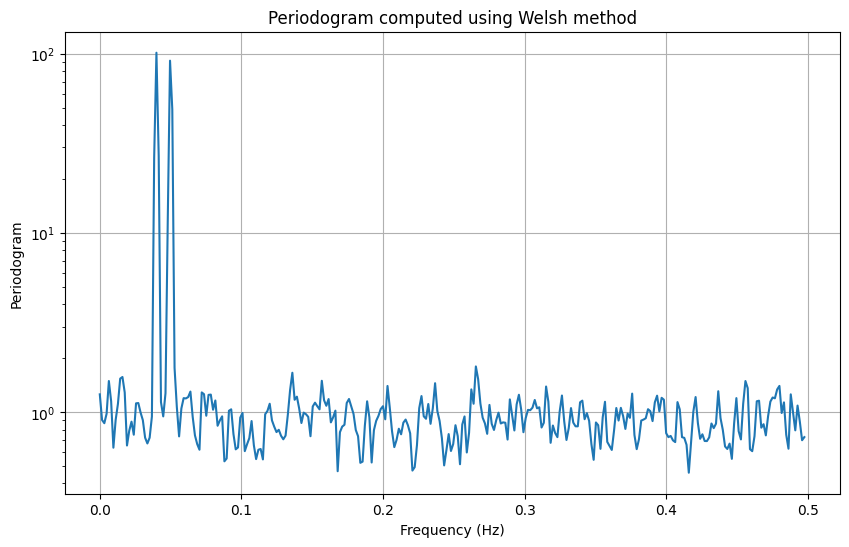

In [ ]:
N = 5000
freqs = [0.04, 0.05]
amps = [1, 1]
signal, t = synthesize_signal(N, freqs, amps)

_, _ = compute_periodogram(signal,fs=1,method="Standard",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Bartlett",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Welsh",L=8,plot_periodogram=True)

___

For ∆ν = |ν1 − ν2| = 0.01

SNR = - 3 dB

The standard method gives the two frequencies, the other two methods are showing two distinct frequencies but with a higher spread around the frequency. The amplitudes are also not the same in the periodogram despite having the same aplitude in the signal.

___

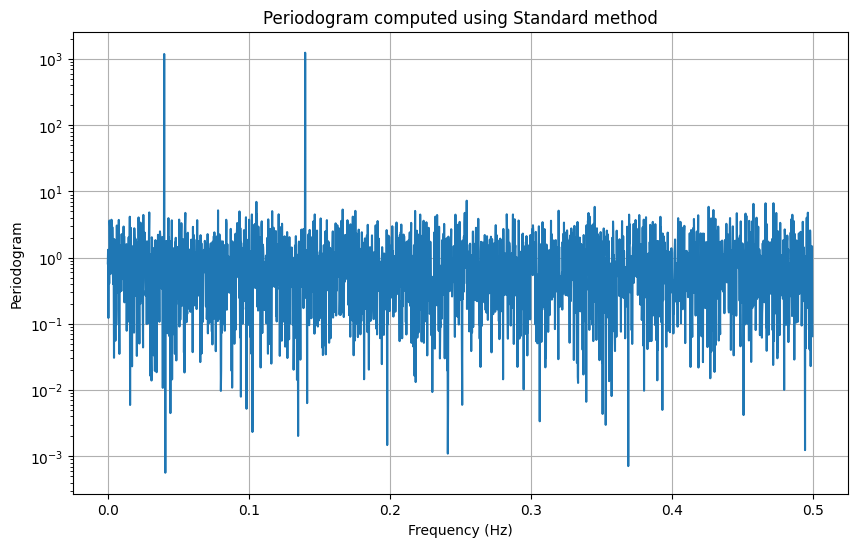

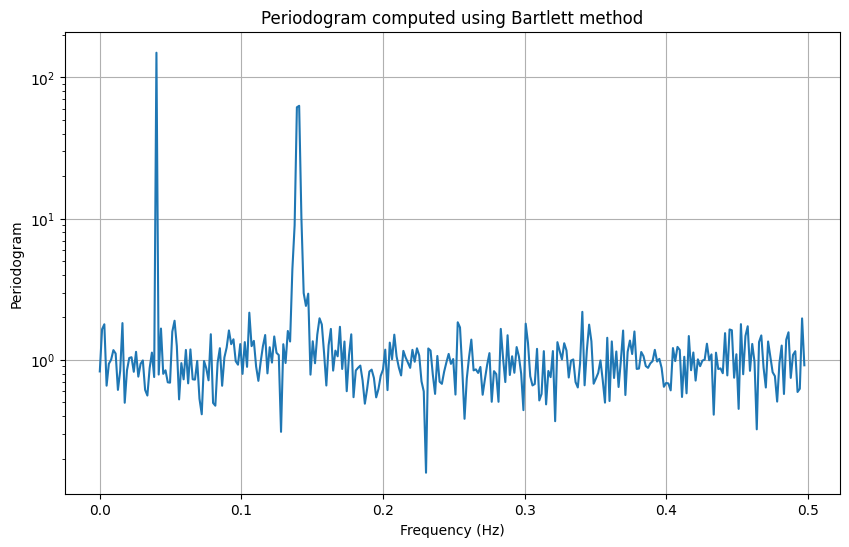

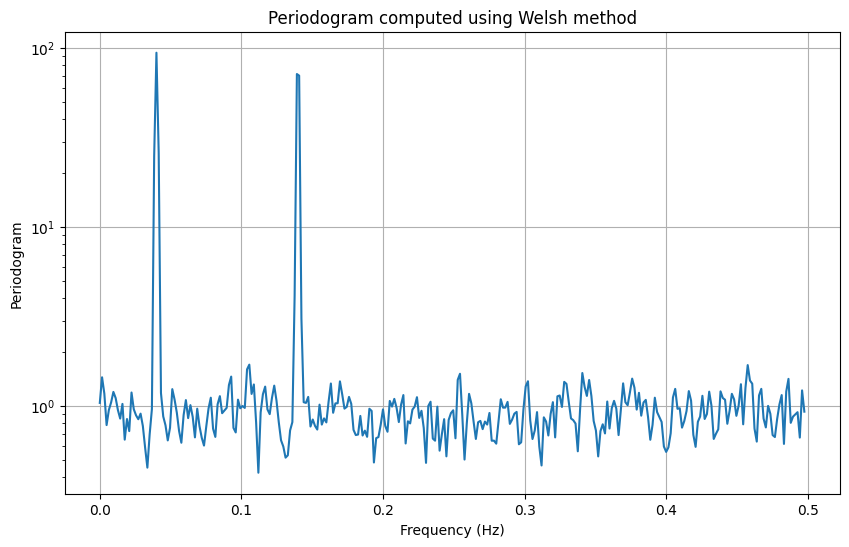

In [ ]:
N = 5000
freqs = [0.04, 0.14]
amps = [1, 1]
signal, t = synthesize_signal(N, freqs, amps)

_, _ = compute_periodogram(signal,fs=1,method="Standard",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Bartlett",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Welsh",L=8,plot_periodogram=True)

___

For ∆ν = |ν1 − ν2| = 0.1

SNR = - 3 dB

The standard method gives the two frequencies, the other two methods are showing two distinct frequencies but with a higher spread around the frequency. The amplitudes are also not the same in the periodogram despite having the same aplitude in the signal.

___

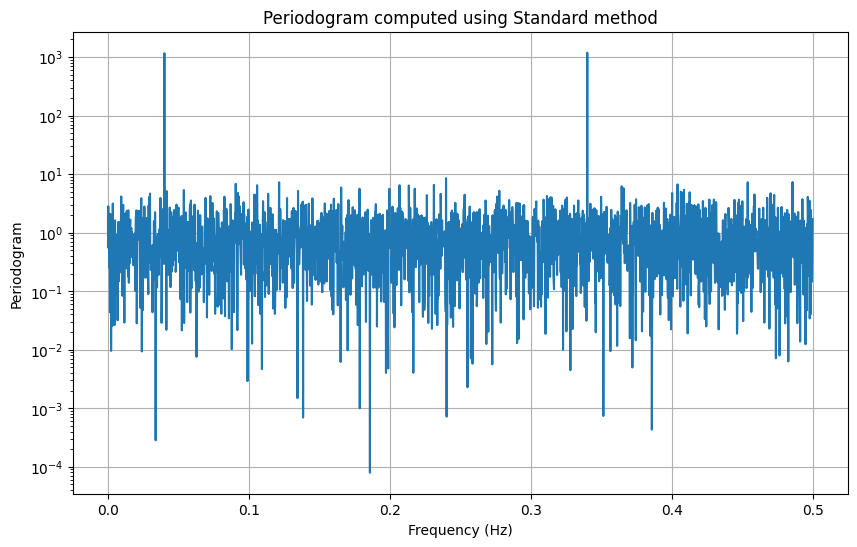

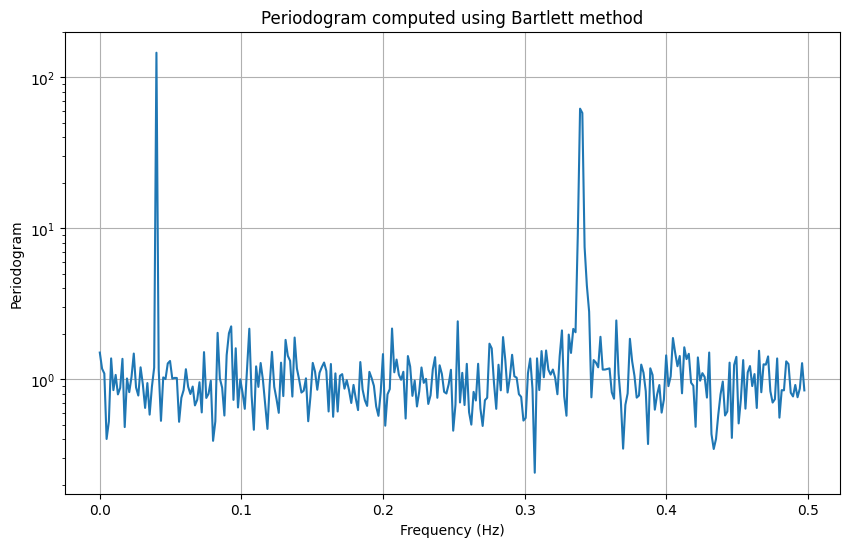

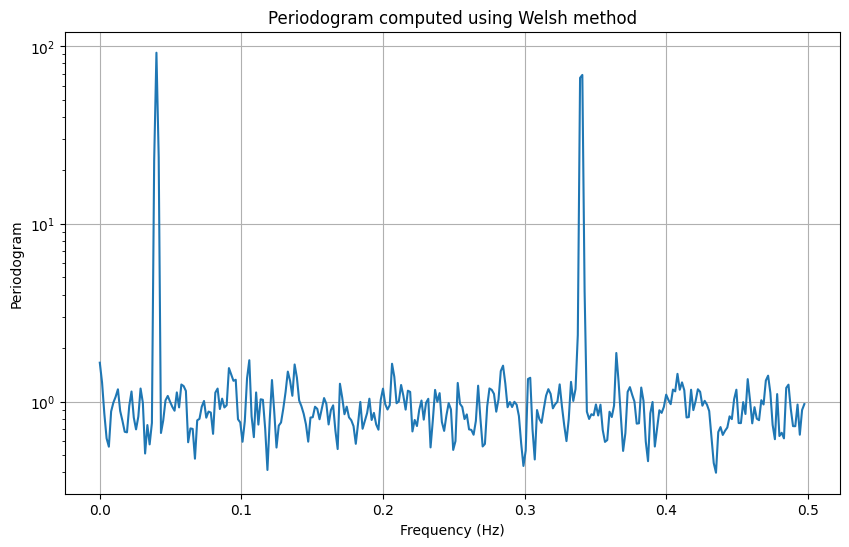

In [ ]:
N = 5000
freqs = [0.04, 0.34]
amps = [1, 1]
signal, t = synthesize_signal(N, freqs, amps)

_, _ = compute_periodogram(signal,fs=1,method="Standard",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Bartlett",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Welsh",L=8,plot_periodogram=True)

___

For ∆ν = |ν1 − ν2| = 0.3

SNR = - 3 dB

The standard method gives the two frequencies, the other two methods are showing two distinct frequencies but with a higher spread around the frequency. The amplitudes are also not the same in the periodogram despite having the same aplitude in the signal.

___

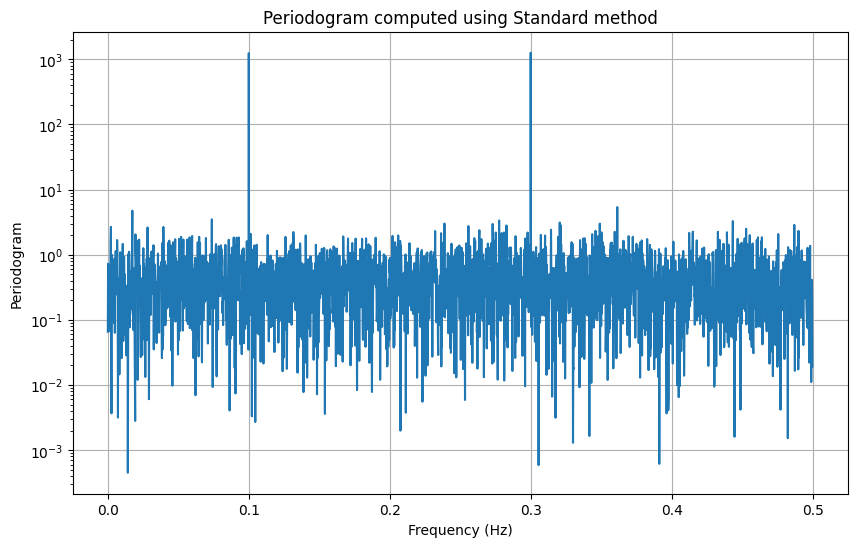

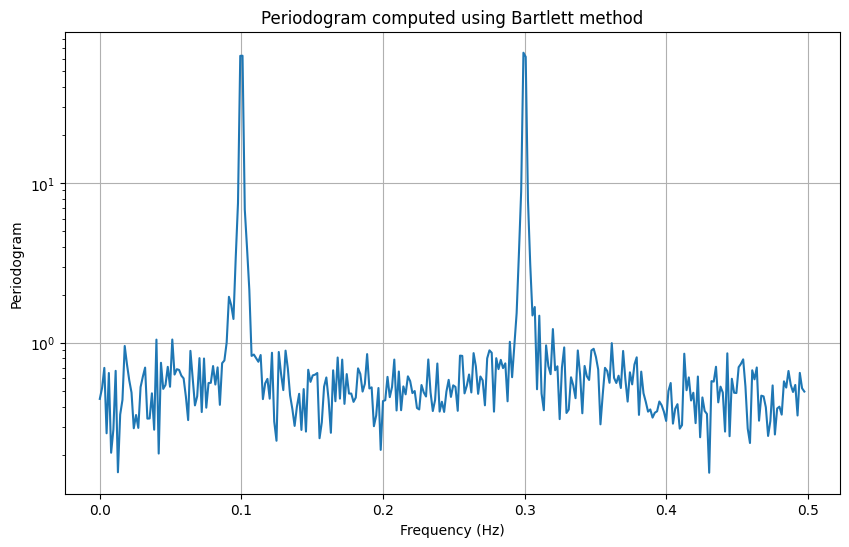

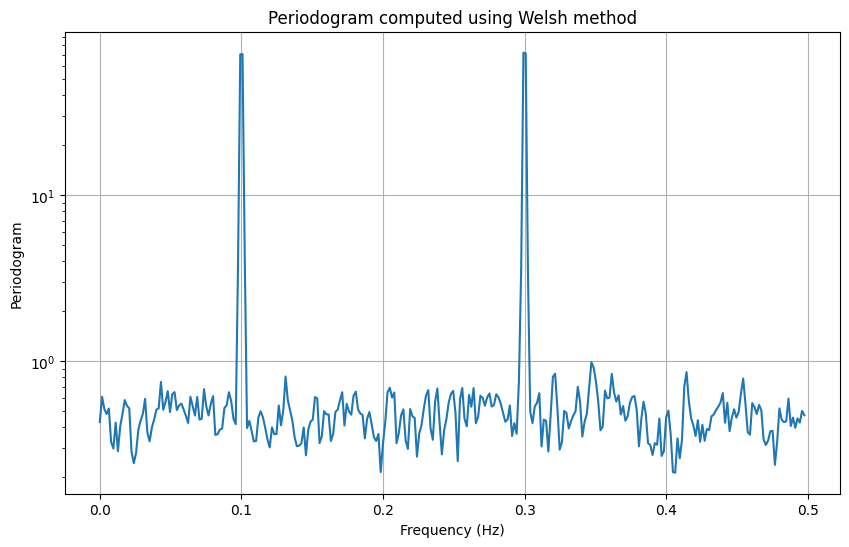

In [ ]:
N = 5000
freqs = [0.1, 0.3]
amps = [1, 1]
signal, t = synthesize_signal(N, freqs, amps, sigma2=0.5)

_, _ = compute_periodogram(signal,fs=1,method="Standard",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Bartlett",L=8,plot_periodogram=True)
_, _ = compute_periodogram(signal,fs=1,method="Welsh",L=8,plot_periodogram=True)

___

For ∆ν = |ν1 − ν2| = 0.2

SNR = + 3 dB

All methods give the correct frequencies and amplitudes with a higher SNR.

___

To conclude, higher SNR gives the correct amplitudes for all methods with the periodogram (no spectral leakage), higher frequency gap means higher spread in frequency for Bartlett and Welsh methods.

___
### 2.3 Parametric estimation : linear prediction
4. Estimate a fourth order AR model using the linear prediction method.


In [ ]:
def estimate_AR4_model(X,order=4):
    lpc_coeffs = librosa.lpc(X, order = order)
    return(lpc_coeffs)

coeffs = estimate_AR4_model(signal)

5. Superimpose the estimated AR model with the previous figures, always by varying the gap ∆ν, as well as the SNR in dB. Comment on the results in terms of resolution.

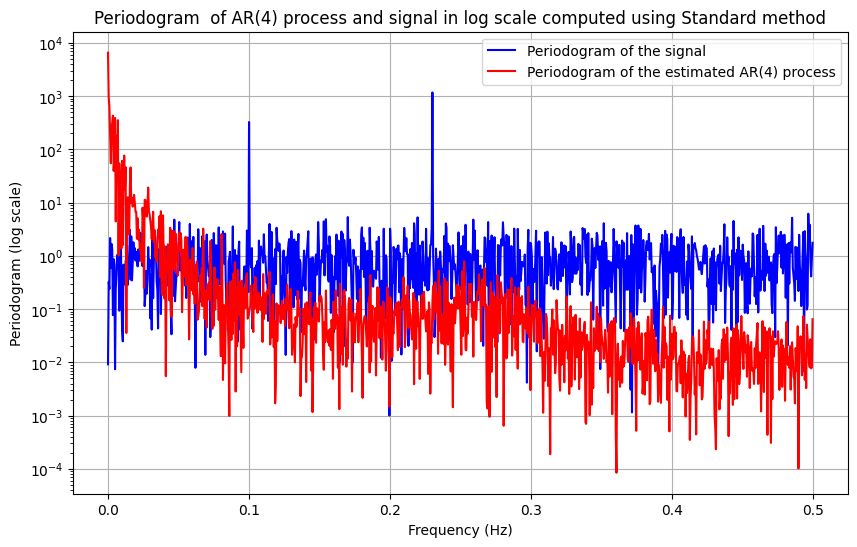

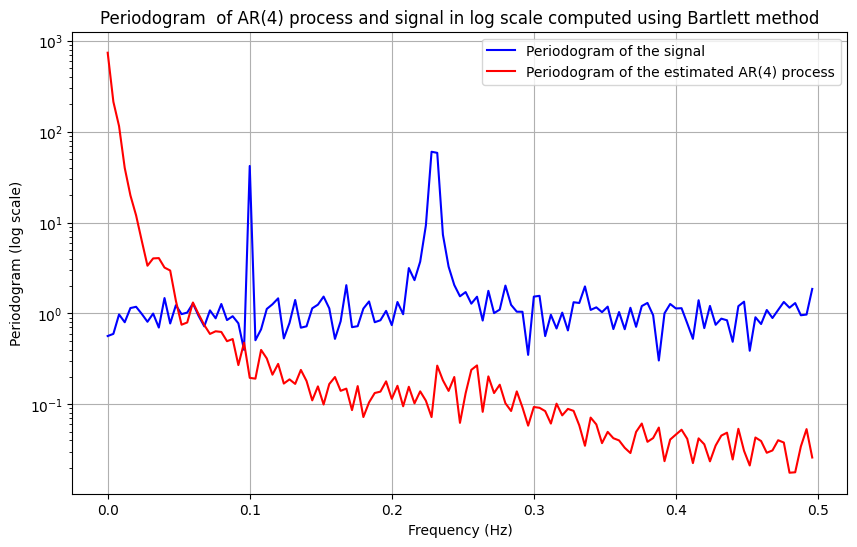

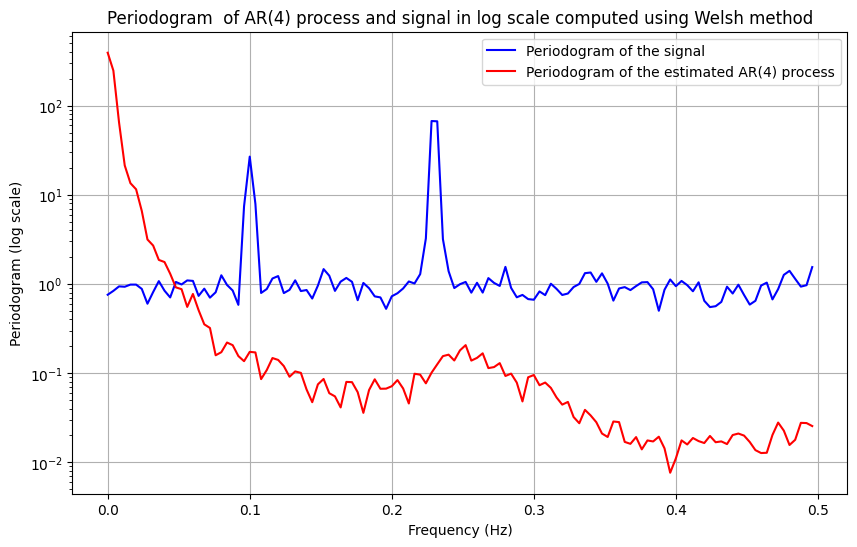

In [166]:
N = 2000
freqs = [0.1, 0.23]
amps = [0.8, 1.5]
synth_signal, t = synthesize_signal(N, freqs, amps)

AR4_param = estimate_AR4_model(synth_signal)

methods = ["Standard","Bartlett","Welsh"]

def plot_signal_and_estimated_AR4_process(signal,AR4_parameters,fs=1.0,method='Standard',L=8):
    N = len(signal)
    freqs = np.fft.fftfreq(N, 1/fs)
    if method not in methods :
        print(f"Method must be in {methods}")
        return()
    if method == 'Standard':
        Sxx = (np.abs(np.fft.fft(signal))**2)/N
    elif method == 'Bartlett':
        M = N//L #Data segment size
        Sxx = np.zeros(M)
        for i in range(L):
            segment = signal[i*M : (i+1)*M] #We take {X[iM], ... X[(i+1)M-1]} to compute
            Sxx += (np.abs(np.fft.fft(segment, M))**2)/M
        Sxx = Sxx/L
        freqs = np.fft.fftfreq(M, 1/fs)
    elif method == 'Welsh': #We will use hann window for Welsh
        M = N//L
        K = M//2  #Recommended overlapping size
        S = 2*N//M #Number of segments used to average Sxx
        window = np.hanning(M)
        P = np.sum(window**2)/M #Normalizing coefficient
        Sxx = np.zeros(M)
        for i in range(S):
            j = i*K
            if j + M > N: #If we exceed in length
                break
            segment = signal[j:j + M]*window
            Sxx += (np.abs(np.fft.fft(segment, M))**2)/(M*P)
        Sxx = Sxx/S
        freqs = np.fft.fftfreq(M, d=1/fs)
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2], label = 'Periodogram of the signal', color = 'b')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Periodogram (log scale)')
    X = autoregressive_process(AR4_parameters,sigma2,N)
    Sxx, freqs = compute_periodogram(X,fs,method,L,plot_periodogram=False)
    plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2], label = 'Periodogram of the estimated AR(4) process', color = 'r')
    plt.legend()
    plt.title(f'Periodogram  of AR(4) process and signal in log scale computed using {method} method')
    plt.grid()
    plt.show()
    
plot_signal_and_estimated_AR4_process(synth_signal,AR4_param,method='Standard')
plot_signal_and_estimated_AR4_process(synth_signal,AR4_param,method='Bartlett')
plot_signal_and_estimated_AR4_process(synth_signal,AR4_param,method='Welsh')

The fourth order AR model, when changing the frequency gap for a smaller one, seems to be diverving (its amplitude just blows up). I am not sure why it does it, I think the AR(4) estimated process based on this example is not stable, and has root(s) outside the unit circle, thus its amplitude is skyrocketing.

We can either change the order of the AR(4), or I made a mistake but the code estimates an AR(4) process based on the signal and plots its periodogram alongside the signal's periodogram.

___

#### 2.4. Parametric estimation : Capon estimator

6. Code a function that implements the Capon estimator.
7. Compare the resolution of this method with the two previous methods, always by varying ∆ν, as well as the SNR in dB.

In [ ]:
def capon_estimator():
    pass

### 3 Autoregressive-moving-average process
#### 3.1 Synthesis

1. Code a function that synthesizes an autoregressive-moving-average (ARMA) process of length N, defined by its AR and MA coefficients and by the innovation variance $\sigma ^2$

ARMA(p,q) equation :

$$ X_t = \sum _{i=1} ^p \phi _i X_{t-i} + \sum _{j=1} ^q \theta _j \epsilon _{t-j} + \epsilon _t $$

In [169]:
def arma_process(AR_coeffs,MA_coeffs,sigma2,N):
    p = len(AR_coeffs)
    q = len(MA_coeffs)
    noise = np.random.normal(0, np.sqrt(sigma2), N+q)
    x = np.zeros(N+q)
    for t in range(max(p,q), N+q):
        for i in range(p):
            x[t] += AR_coeffs[i]*x[t-i-1]
        for j in range(q):
            x[t] += MA_coeffs[j]*noise[t-j-1]
        x[t] += noise[t]
    return x[q:]


#### 3.2 Non-parametric estimation : periodogram
2. Display the periodograms obtained with the different methods, in the case of an ARMA process of order (1, 1) whose parameters can be chosen by hand. We will superimpose in each case the periodogram with the known PSD of the ARMA process.

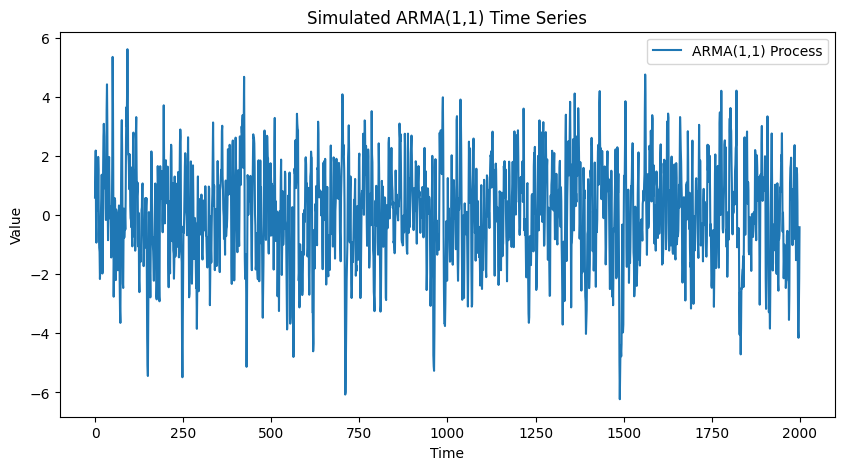

In [172]:
ar_coeffs = [0.5]
ma_coeffs = [0.7]  # ARMA(1,1) process
sigma2 = 1.0
N = 2000

arma_signal = arma_process(ar_coeffs, ma_coeffs, sigma2, N)

plt.figure(figsize=(10, 5))
plt.plot(range(N), arma_signal, label="ARMA(1,1) Process")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Simulated ARMA(1,1) Time Series")
plt.legend()
plt.show()

Exact formula of spectral density for a ARMA(1,1) process :

$ S_{X,X}(\nu) = \sigma ^2 \frac{|1+\theta_1 e^{-2i\pi \nu}|^2}{|1-\phi _1 e^{-2i \pi \nu}|^2} $

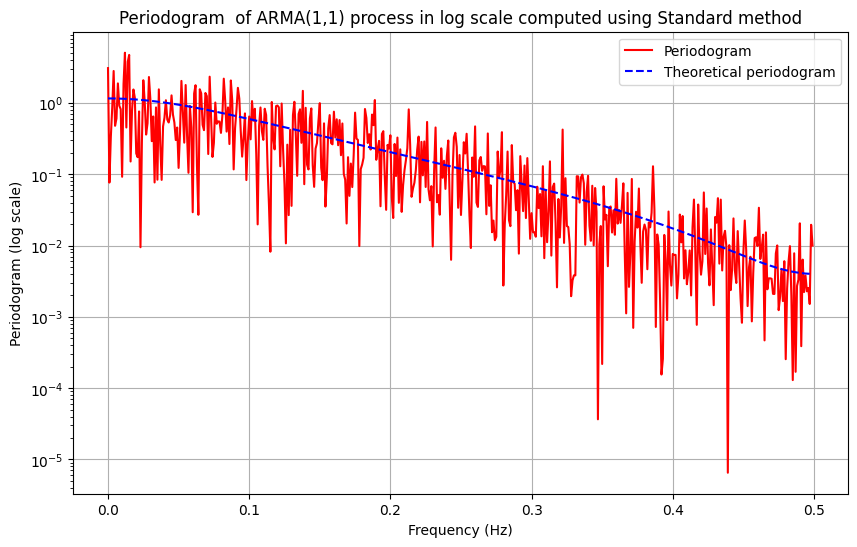

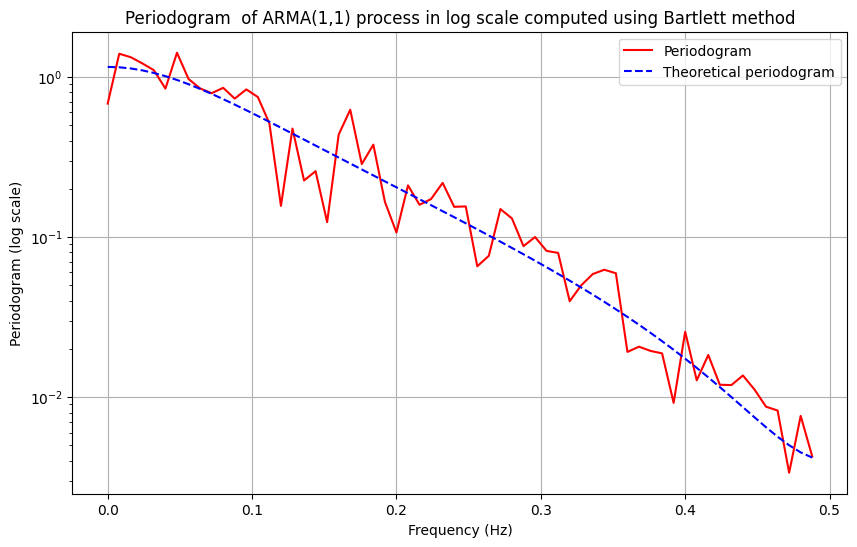

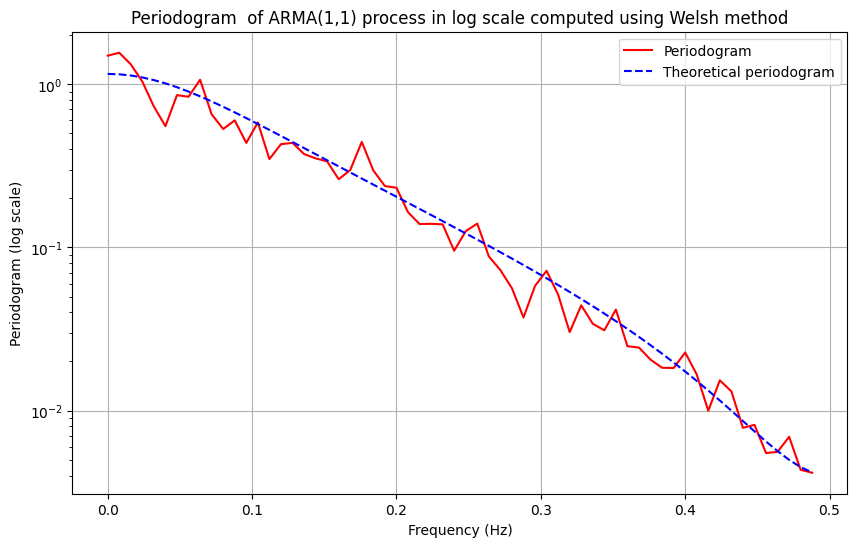

In [176]:
N = 1000
sigma2 = 0.1

def plot_estimated_arma_process(AR_param,MA_param,fs=1.0,method='Standard',L=8):
    X = arma_process(AR_param,MA_param,sigma2,N)
    Sxx, freqs = compute_periodogram(X,fs,method,L,plot_periodogram=False)
    true_Sxx = sigma2*(1+2*MA_param[0]*np.cos(2*np.pi*freqs)+MA_param[0]**2)/(1-2*AR_param[0]*np.cos(2*np.pi*freqs)+AR_param[0]**2)
    coeff_estimated = estimate_AR_model(X,1)
    plt.figure(figsize=(10, 6))
    plt.semilogy(freqs[:len(freqs)//2], Sxx[:len(Sxx)//2], label = 'Periodogram', color = 'r')
    plt.semilogy(freqs[:len(freqs)//2], true_Sxx[:len(true_Sxx)//2], label = 'Theoretical periodogram', color = 'b', linestyle='dashed')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Periodogram (log scale)')
    plt.legend()
    plt.title(f'Periodogram  of ARMA(1,1) process in log scale computed using {method} method')
    plt.grid()
    plt.show()
    
plot_estimated_arma_process(ar_coeffs,ma_coeffs,method='Standard')
plot_estimated_arma_process(ar_coeffs,ma_coeffs,method='Bartlett')
plot_estimated_arma_process(ar_coeffs,ma_coeffs,method='Welsh')

3. Compare these different estimators in terms of bias and variance

There is no bias for the different estimators, however the variance is much higher for the standard method.